# Sentiment analysis
"Small" subsets Data from Grocery and Gourmet Food
https://nijianmo.github.io/amazon/index.html (May 1996 - Oct 2018)

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
asin - ID of the product, e.g. 0000013714
reviewerName - name of the reviewer
vote - helpful votes of the review
style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
reviewText - text of the review
overall - rating of the product
summary - summary of the review
unixReviewTime - time of the review (unix time)
reviewTime - time of the review (raw)
image - images that users post after they have received the product

* Metadata

asin - ID of the product, e.g. 0000031852
title - name of the product
feature - bullet-point format features of the product
description - description of the product
price - price in US dollars (at time of crawl)
imageURL - url of the product image
imageURL - url of the high resolution product image
related - related products (also bought, also viewed, bought together, buy after viewing)
salesRank - sales rank information
brand - brand name
categories - list of categories the product belongs to
tech1 - the first technical detail table of the product
tech2 - the second technical detail table of the product
similar - similar product table

In [1]:
# Data manipulation
import pandas as pd
pd.set_option('max_columns', 200)
import numpy as np
# Importing
import os
import gzip
import json
import yaml
# Data visualisation
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns

config = yaml.safe_load(open('config.yml'))

# Output folder
out_dir = config['in_dir']
raw_dir = config['raw_dir']
# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    df = {}
    for i, d in enumerate(parse(path)):
        df[i] = d
    return pd.DataFrame.from_dict(df, orient='index')

In [2]:
# 15min to load
raw_df = getDF(os.path.join(raw_dir, 'Electronics_5.json.gz'))

raw_df.head()
#print(df.info())
#df.describe()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


## Feature understanding
Since reviews is the main variable being evaluated, how are they spread across the dataset?

In [3]:
# How many distinct products in the dataset?
summary_df = raw_df['asin'].value_counts()
#top_products = list(summary_df.head(10).index)

summary_df

B003L1ZYYW    8617
B0019HL8Q8    8160
B0019EHU8G    7777
B0015DYMVO    7380
B000VS4HDM    6802
              ... 
B0015C1RGS       1
B0012KHNZW       1
B0013MYX8E       1
B00125Q77C       1
B000WGS5B8       1
Name: asin, Length: 160052, dtype: int64

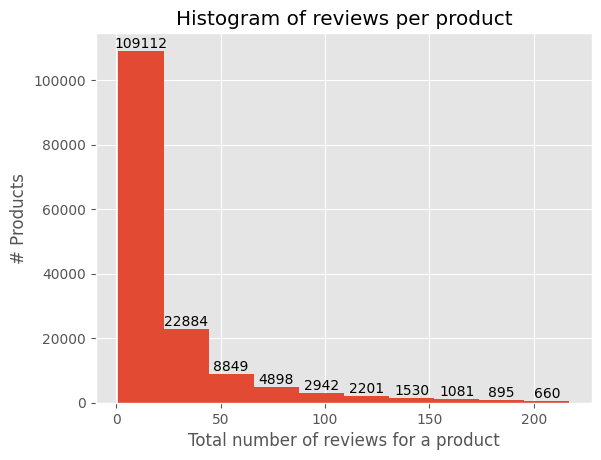

In [4]:
# Excluding the top 5000 products (non representative outliers)
counts, edges, bars = plt.hist(summary_df[5000:])
plt.bar_label(bars)

plt.title("Histogram of reviews per product")
plt.xlabel("Total number of reviews for a product")
plt.ylabel("# Products")

# Alternatively a boxplot
#plt.boxplot(summary_df)
plt.show()

# The absolute majority of product have less than 50 reviews.

## Data Preparation

In [5]:
# Limiting the dataset to the most representative examples
# That is for products that are close to the mean +-threshold
threshold = config['threshold']
median_df = summary_df[(summary_df >= summary_df.mean()*(1-threshold)) &
                  (summary_df <= summary_df.mean()*(1+threshold))]

df = raw_df[raw_df['asin'].isin(list(median_df.index))]
# Alternative
#product_df = df.query('asin in @median_products')

print(f'Total of {len(median_df)} products remain')

Total of 632 products remain


In [6]:
# Checking for missing values
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': round(df.isnull().sum() * 100 / len(df),0)})\
                                 .sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
image,image,98.0
vote,vote,80.0
style,style,58.0
overall,overall,0.0
verified,verified,0.0
reviewTime,reviewTime,0.0
reviewerID,reviewerID,0.0
asin,asin,0.0
reviewerName,reviewerName,0.0
reviewText,reviewText,0.0


In [7]:
# Removing unecessary columns, some due to too many missing values
print(df.columns)

df = df[['asin', 'overall', 'reviewText', 'summary', 'unixReviewTime', 'style', 'vote']]
# Alternative
#product_df.drop(columns=['verified', 'reviewerID', 'style', 'reviewerName','unixReviewTime', 'vote', 'image'])


# Check for duplicated values
#product_df.loc[product_df.duplicated(subset=['reviewText', 'asin', 'reviewerID'], keep='first')]

df = df.loc[~df.duplicated(subset=['reviewText', 'asin', 'unixReviewTime'])]

# Only rows which has review text
df = df.dropna(subset=['reviewText'])

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')


In [8]:
import re

def amazon_date_to_iso(date):
    '''
    From the format '*m *d, yyyy' to 'yyyy-mm-dd'
    '''
    # Month
    m_= re.search(r'\s', date)
    m = date[0:m_.start()]
    if len(m)<2:
        m = '0' + m
    
    # Day
    d_ = re.search(r', ', date)
    d = date[m_.end():d_.start()]
    if len(d)<2:
        d = '0' + d

    # Year
    y = date[d_.end():]
    if len(y)<4:
        y = '20' + y
    return y+'-'+m+'-'+d

In [9]:
# Changing data types for memory usage efficiency
#https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes

# Max value of votes
#print(product_df['vote'].dropna().astype('Int32', errors='ignore').max())

df = df.astype({'asin': 'string',
                'overall': 'category',
                'reviewText': 'string',
                'summary': 'string',
                'style': 'string',
                'vote': 'Sparse[int]', #'Int16',
                #'verified': np.bool_,
                #'reviewTime': np.timedelta64,                              
                }, errors='ignore')

df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: pd.to_datetime(x, unit='s'))

# To check improvement
#product_df.memory_usage(index=False, deep=True)

# Renaming columns for clarity
df = df.rename(columns={'reviewText': 'text',
                        'unixReviewTime': 'date',
                        }) \
     .reset_index(drop=True).copy()

In [10]:
# Exporting
#!pip install fastparquet
df.to_parquet(os.path.join(out_dir, 'product_df.parquet'))

# Testing import
#import_test = pd.read_parquet(os.path.join(out_dir, 'product_df.parquet'))
#import_test

In [12]:
print(f"Shape of the new df: {raw_df.shape.shape}\n")
print(f"Shape of the new df: {df.shape}\n")
df.columns

(26135, 7)


Index(['asin', 'overall', 'text', 'summary', 'date', 'style', 'vote'], dtype='object')

## Text Analytics
Examples:
* Relashionships between features 
* Word frequency analysis,
* Sentence length analysis,
* Average word length analysis

In [14]:
# Readability
#!pip install textstat
import textstat
#df['text_standard']=df['text'].apply(lambda x: textstat.text_standard(x))
# df['dale_chall_score']=df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
# df['flesh_reading_ease']=df['text'].apply(lambda x: textstat.flesch_reading_ease(x))
df['gunning_fog']=df['text'].apply(lambda x: textstat.gunning_fog(x))
df['reading_time']=df['text'].apply(lambda x: textstat.reading_time(x))

# Define the function to count words
def count_words(string):
    words = string.split()
    return len(words)

# Count words
df['text_len'] = df['text'].apply(count_words)

# Count letters
#product_df['text_len'] = product_df['text'].str.len()

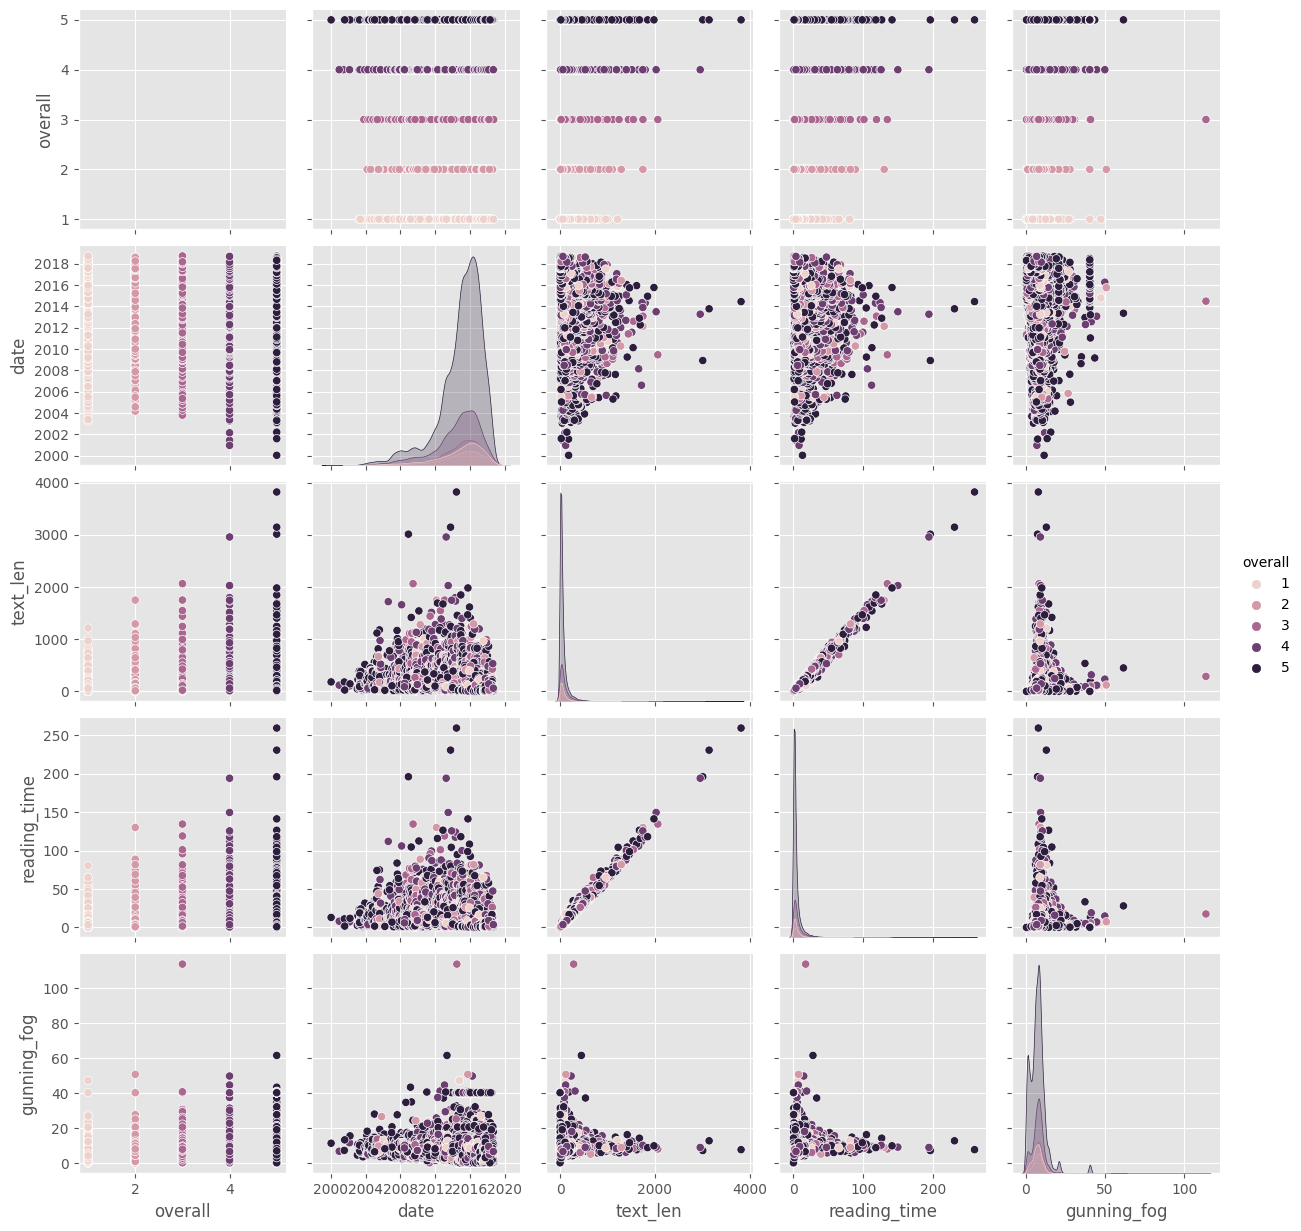

In [16]:
# To make the pairplot to check how is the data
df = df.astype({'overall': 'float16'}, errors='ignore')

sns.pairplot(df,
             vars=['overall', 'date', 
             'text_len', 'reading_time', 'gunning_fog'],
            hue='overall'
            )
plt.show()

# The dataset is skewed towards positive reviews (score > 3)

# Meta information dataframe

In [17]:
#12min to load
meta_df = getDF(os.path.join(raw_dir, 'meta_Electronics.json.gz'))
print(meta_df.info())
meta_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786445 entries, 0 to 786444
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   category         786445 non-null  object
 1   tech1            786445 non-null  object
 2   description      786445 non-null  object
 3   fit              786445 non-null  object
 4   title            786445 non-null  object
 5   also_buy         786445 non-null  object
 6   tech2            786445 non-null  object
 7   brand            786445 non-null  object
 8   feature          786445 non-null  object
 9   rank             786445 non-null  object
 10  also_view        786445 non-null  object
 11  main_cat         786445 non-null  object
 12  similar_item     786445 non-null  object
 13  date             786445 non-null  object
 14  price            786445 non-null  object
 15  asin             786445 non-null  object
 16  imageURL         786445 non-null  object
 17  imageURLHi

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Electronics, Camera &amp; Photo, Video Survei...",,[The following camera brands and models have b...,,Genuine Geovision 1 Channel 3rd Party NVR IP S...,[],,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...","[>#3,092 in Tools &amp; Home Improvement &gt; ...",[],Camera &amp; Photo,,"January 28, 2014",$65.00,0011300000,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Electronics, Camera &amp; Photo]",,[This second edition of the Handbook of Astron...,,"Books ""Handbook of Astronomical Image Processi...",[0999470906],,33 Books Co.,[Detailed chapters cover these fundamental top...,"[>#55,933 in Camera &amp; Photo (See Top 100 i...","[0943396670, 1138055360, 0999470906]",Camera &amp; Photo,,"June 17, 2003",,0043396828,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Electronics, eBook Readers &amp; Accessories,...",,[A zesty tale. (Publishers Weekly)<br /><br />...,,One Hot Summer,"[0425167798, 039914157X]",,Visit Amazon's Carolina Garcia Aguilera Page,[],"3,105,177 in Books (",[],Books,,,$11.49,0060009810,[],[],NaN
3,"[Electronics, eBook Readers & Accessories, eBo...",,[],,Hurray for Hattie Rabbit: Story and pictures (...,"[0060219521, 0060219580, 0060219394]",,Visit Amazon's Dick Gackenbach Page,[],"2,024,298 in Books (","[0060219521, 0060219475, 0060219394]",Books,,,.a-section.a-spacing-mini{margin-bottom:6px!im...,0060219602,[],[],NaN
4,"[Electronics, eBook Readers & Accessories, eBo...",,[&#8220;sex.lies.murder.fame. is brillllli&#82...,,sex.lies.murder.fame.: A Novel,[],,Visit Amazon's Lolita Files Page,[],"3,778,828 in Books (",[],Books,,,$13.95,0060786817,[],[],NaN


In [18]:
meta_product_df = meta_df[meta_df['asin'].isin(list(median_df.index))]
meta_product_df.reset_index(inplace = True, drop=True)

meta_product_df.to_parquet(os.path.join(out_dir, 'meta_product_df.parquet'))

# Testing import
#import_test = pd.read_parquet(os.path.join(out_dir, 'meta_product_df.parquet'))
#import_test